Loaded 2503 images with 898 unique labels.
Training set: 2252 images
Testing set: 251 images


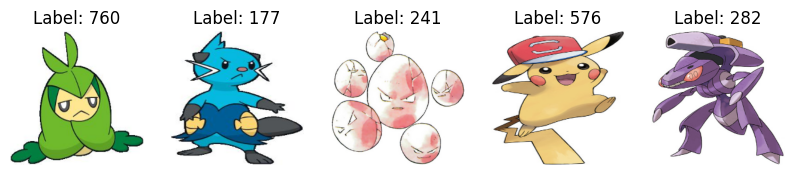

In [1]:
# Step 1: Extract ZIP File
from zipfile import ZipFile

with ZipFile("archive.zip", 'r') as zObject:
    zObject.extractall()

# Step 2: Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Step 3: Load Images
def load_images_from_folders(root_dir, img_size=(224, 224)):  # Larger image size for better details
    data = []
    labels = []
    folder_names = sorted(os.listdir(root_dir))  # Alphabetical order

    for folder in folder_names:
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):  # Only images
                    img = cv2.imread(file_path)  # Load in color (BGR)
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, img_size)  # Resize to standard input size
                    data.append(img)
                    labels.append(folder)  # Use folder name as label

    data = np.array(data, dtype=np.float32) / 255.0  # Normalize to [0,1]
    old_labels = labels
    labels = LabelEncoder().fit_transform(labels)  # Convert text labels to numbers

    return data, labels, old_labels

# Step 4: Load Data
root_directory = "images"  # Adjust if your extracted folder name differs
X, y, y_names = load_images_from_folders(root_directory)

print(f"Loaded {len(X)} images with {len(set(y))} unique labels.")

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=64)

print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")

# Step 6: Display Sample Images
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
# Unfreeze last few layers
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Freeze first 100 layers
    layer.trainable = False

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(len(set(y)), activation='softmax')(x)  # Output layer for Pokémon classes

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_split=0.1, batch_size=64)

# Step 10: Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
model.save("PokeTrainer.keras")  # Save trained model


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 808ms/step - accuracy: 0.0124 - loss: 6.8263 - val_accuracy: 0.0000e+00 - val_loss: 16.9479
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1473 - loss: 5.5255 - val_accuracy: 0.0088 - val_loss: 9.0287
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.5696 - loss: 2.5391 - val_accuracy: 0.0088 - val_loss: 13.9183
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.8838 - loss: 0.6531 - val_accuracy: 0.0044 - val_loss: 15.6216
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9837 - loss: 0.1104 - val_accuracy: 0.0133 - val_loss: 18.5284
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9923 - loss: 0.0452 - val_accuracy: 0.0088 - val_loss: 16.7101
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.9962 - loss: 0.0197 - val_accuracy: 0.0265 - val_loss: 14.8976
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 8

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


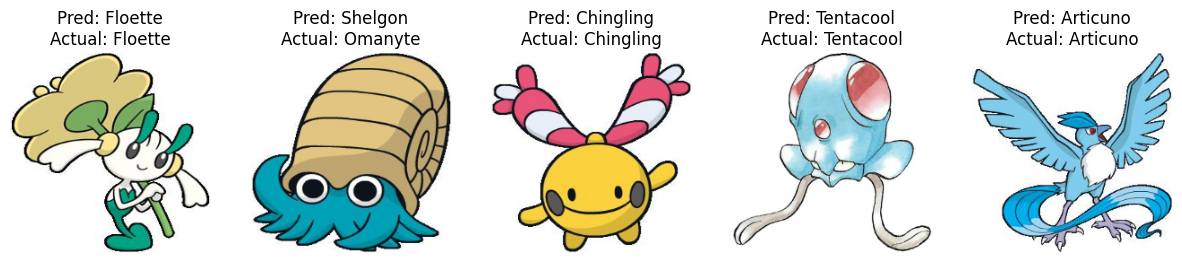

In [3]:
# Select a few test images
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]

# Make predictions
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert label numbers back to folder names
label_encoder = LabelEncoder()
label_encoder.fit(y_names)  # Fit encoder with original folder names
predicted_names = label_encoder.inverse_transform(predicted_labels)
actual_names = label_encoder.inverse_transform(sample_labels)

# Display images with predictions
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {predicted_names[i]}\nActual: {actual_names[i]}")
    plt.axis('off')
plt.show()


In [5]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#model.load_weights("saved_model.h5")  # Load previous weights

# Load Pretrained Model
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Fine-tuning (Unfreeze last 30 layers)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Add Custom Layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)  # Pass the output from GlobalAveragePooling2D to this Dense layer
output = Dense(len(set(y)), activation='softmax')(x)  # Pass the output from the previous Dense layer to this Dense layer

model = Model(inputs=base_model.input, outputs=output)

# Use Adam Optimizer (Instead of SGD)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model = load_model("PokeTrainer.keras")  # Load saved model

# Learning Rate Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Data Augmentation (Only for Training Data)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    #horizontal_flip=True,
    #brightness_range=[0.8, 1.2],
    #fill_mode='nearest'
)

train_datagen.fit(X_train)

# Train Model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=128),
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[lr_scheduler]
)

# Evaluate Model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")
model.save("PokeTrainer.keras")

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.0105 - loss: 6.8429 - val_accuracy: 0.0080 - val_loss: 7.1220 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.1330 - loss: 5.7511 - val_accuracy: 0.0279 - val_loss: 7.9288 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.3867 - loss: 3.6186 - val_accuracy: 0.0398 - val_loss: 7.6971 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7520 - loss: 1.5295 - val_accuracy: 0.0797 - val_loss: 6.1423 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9059 - loss: 0.5444 - val_accuracy: 0.1315 - val_loss: 6.3138 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9606 - loss: 0.2183 - val_accuracy: 0.1673 - val_loss: 5.7409 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.9834 - loss: 0.1184 - val_acc

Transfer learning accuracy rate 63%
Transfer learning with data augumentation and learning rate scheduler 70%
basic model from scratch 12%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


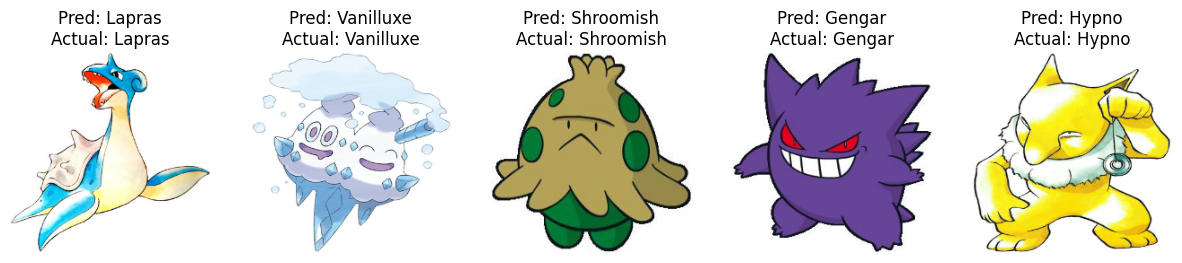

In [6]:
# Select a few test images
num_samples = 5
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_images = X_test[indices]
sample_labels = y_test[indices]

# Make predictions
predictions = model.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert label numbers back to folder names
label_encoder = LabelEncoder()
label_encoder.fit(y_names)  # Fit encoder with original folder names
predicted_names = label_encoder.inverse_transform(predicted_labels)
actual_names = label_encoder.inverse_transform(sample_labels)

# Display images with predictions
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(sample_images[i])
    plt.title(f"Pred: {predicted_names[i]}\nActual: {actual_names[i]}")
    plt.axis('off')
plt.show()
